<a href="https://colab.research.google.com/github/DJCordhose/transformers/blob/main/notebooks/mistral-mixtral-4bit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



* https://huggingface.co/mistralai/Mistral-7B-Instruct-v0.2
* https://huggingface.co/mistralai/Mixtral-8x7B-Instruct-v0.1
* https://towardsdatascience.com/mixtral-8x7b-understanding-and-running-the-sparse-mixture-of-experts-0e3fc7fde818
* https://huggingface.co/chat/


In [1]:
!nvidia-smi

Sat Dec 16 11:36:26 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0              43W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [2]:
!pip install -qU transformers

In [3]:
# https://github.com/googlecolab/colabtools/issues/3409
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [4]:
!pip install accelerate bitsandbytes -qU

# with 8bit we get: OutOfMemoryError: CUDA out of memory. Tried to allocate 56.00 MiB. GPU 0 has a total capacty of 39.56 GiB

# with 4Bit, it works on A100, we need just over 24GB

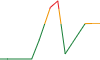

In [5]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

model_id = "mistralai/Mixtral-8x7B-Instruct-v0.1"
# needs just under 16GB when using half precision, 8GB with 8Bit, but poor performance with both
# might need more memory when generating responses
# model_id = "mistralai/Mistral-7B-Instruct-v0.2"

tokenizer = AutoTokenizer.from_pretrained(model_id)

In [ ]:
# model = AutoModelForCausalLM.from_pretrained(model_id)

In [6]:
compute_dtype = getattr(torch, "float16")
from transformers import BitsAndBytesConfig

bnb4_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=compute_dtype,
        bnb_4bit_use_double_quant=True,
)
bnb8_config = BitsAndBytesConfig(
        load_in_8bit=True,
        bnb_8bit_quant_type="nf4",
        bnb_8bit_compute_dtype=compute_dtype,
        bnb_8bit_use_double_quant=True,
)
bnb_config = bnb4_config


In [7]:
model = AutoModelForCausalLM.from_pretrained(model_id, quantization_config=bnb_config)

Loading checkpoint shards:   0%|          | 0/19 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

In [9]:
# model = AutoModelForCausalLM.from_pretrained(model_id, torch_dtype=torch.float16).to(0)

In [13]:
model

MixtralForCausalLM(
  (model): MixtralModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x MixtralDecoderLayer(
        (self_attn): MixtralAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MixtralRotaryEmbedding()
        )
        (block_sparse_moe): MixtralSparseMoeBlock(
          (gate): Linear4bit(in_features=4096, out_features=8, bias=False)
          (experts): ModuleList(
            (0-7): 8 x MixtralBLockSparseTop2MLP(
              (w1): Linear4bit(in_features=4096, out_features=14336, bias=False)
              (w2): Linear4bit(in_features=14336, out_features=4096, bias=False)
              (w3): Linear4bit(in_features=4096, out_feat

In [11]:
def generate(prompt):
  inputs = tokenizer(prompt, return_tensors="pt").to(0)
#  outputs = model.generate(**inputs, max_new_tokens=20)
  outputs = model.generate(**inputs, max_new_tokens=200)
  return tokenizer.decode(outputs[0], skip_special_tokens=True)


In [16]:
%%time

question = "Hallo, was ist die beste deutsche Krankenversicherung?"
answer = generate(question)
print(answer)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Hallo, was ist die beste deutsche Krankenversicherung?

Die beste deutsche Krankenversicherung ist die Techniker Krankenkasse (TK). Sie ist die größte gesetzliche Krankenkasse in Deutschland und bietet ein umfassendes Leistungsspektrum, hohe Kundenzufriedenheit und niedrige Beiträge.

Die TK überzeugt mit einer Vielzahl von Extraleistungen wie Osteopathie, Homöopathie, Akupunktur und Psychotherapie. Zudem bietet sie eine umfangreiche Zahnversorgung, Brillen und Kontaktlinsen sowie eine bequeme Online-Geschäftsstelle.

Die TK ist auch bekannt für ihre schnelle und unkomplizierte Bearbeitung von Anträgen und Leistungsanfragen. Sie hat ein dichtes Net
CPU times: user 30.9 s, sys: 0 ns, total: 30.9 s
Wall time: 30.9 s


In [17]:
!nvidia-smi

Sat Dec 16 11:46:49 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0              49W / 400W |  24921MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--